In [83]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfb = tfp.bijectors
from tensorflow_probability.python import math as tfp_math
from tensorflow_probability.python.internal import prefer_static
import sonnet as snt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import scipy

import time

from tqdm.notebook import tqdm

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Bijector

Define a bijector, $b : \vec{x} \mapsto \vec{y}$, that moves coordinates along curves defined by local "velocity" fields. The transformation is defined by the following differential equation:
$$
  \frac{\mathrm{d}\vec{x}}{\mathrm{d}t} = \vec{v}_{c}\left(t,\vec{x}\right) \, ,
$$
with $\vec{x}\left(0\right) = \vec{x}$ and $\vec{y} = \vec{x}\left(1\right)$.

The inverse, $b^{-1} : \vec{y} \mapsto \vec{x}$, is easy to obtain: integrate the above ODE backwards, from $t = 1$ to $t = 0$.

For the purposes of training, we also implement a function that calculates the path length of the transformation for each input coordinate. During training, we can regularize the transformation by penalizing larger path lengths.

In [3]:
class CondMLP(snt.Module):
    def __init__(self, n_cond, n_out, n_hidden, hidden_size,
                 activation=tf.math.tanh, name=None):
        super(CondMLP, self).__init__(name=name)
        self.hidden = [
            snt.Linear(hidden_size, name=f'hidden{i}')
            for i in range(n_hidden)
        ]
        self.output = snt.Linear(n_out, name='output')
        self.n_cond = n_cond
        self.activation = activation

    def __call__(self, xc):
#         x,c = tf.split(xc, [-1,self.n_cond], axis=1)
        y = xc
        for i,h in enumerate(self.hidden):
            if i != 0:
                y = tf.concat([y,xc], axis=1)
            y = h(y)
            y = self.activation(y)
        y = self.output(y)
        return y

In [99]:
class CatMLP(snt.Module):
    def __init__(self, n_cat, n_out, n_hidden, hidden_size,
                 activation=tf.math.tanh, name=None):
        super(CatMLP, self).__init__(name=name)
        self.hidden = [
            snt.Linear(hidden_size, name=f'hidden{i}')
            for i in range(n_hidden)
        ]
        self.output = snt.Linear(n_out, name='output')
        self.n_cat = n_cat
        self.activation = activation

    def __call__(self, x, c):
        c = tf.one_hot(c, self.n_cat)
        y = tf.concat([x, c], axis=1)
        for i,h in enumerate(self.hidden):
            if i != 0:
                y = tf.concat([y,x,c], axis=1)
            y = h(y)
            y = self.activation(y)
        y = self.output(y)
        return y

In [4]:
mlp = CondMLP(1, 3, 5, 16)
mlp(tf.random.normal([25,3]))

2023-06-04 17:10:31.077849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 17:10:32.550778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20741 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-06-04 17:10:32.552281: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20965 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:d8:00.0, compute capability: 7.5


<tf.Tensor: shape=(25, 3), dtype=float32, numpy=
array([[ 0.15627444,  0.13178793, -0.53725946],
       [-0.1719646 , -0.21401854,  0.05659806],
       [-0.05471672, -0.00761615, -0.2085035 ],
       [ 0.1633352 ,  0.02440219, -0.54785174],
       [-0.03840129, -0.00098969, -0.290869  ],
       [ 0.06010406,  0.00483351,  0.14683592],
       [-0.29450932, -0.32008174,  0.4926283 ],
       [ 0.21681829,  0.17487484, -0.27032578],
       [-0.17001717, -0.09470295,  0.1336877 ],
       [-0.16896361, -0.3431355 ,  0.19027916],
       [ 0.13261366,  0.28189227,  0.03995774],
       [-0.1542603 , -0.18380803,  0.20640892],
       [-0.23996843, -0.2859244 ,  0.1716676 ],
       [-0.21656583, -0.09048905,  0.6480977 ],
       [ 0.13166688, -0.20442112, -0.4305778 ],
       [ 0.01101301,  0.17584503,  0.3335994 ],
       [ 0.07410496,  0.03780684, -0.45974463],
       [-0.00482914, -0.26319525, -0.26856303],
       [-0.059373  ,  0.24331757,  0.38044453],
       [ 0.1559349 ,  0.28452522, -0.05

In [94]:
mlp = CatMLP(4, 3, 5, 16)
mlp(tf.random.normal([5,3]), tf.random.uniform([5], minval=0, maxval=3, dtype=tf.int32))

tf.Tensor(
[[-1.1542916  -0.94703925  0.5301101   0.          0.          1.
   0.        ]
 [ 0.79149586  0.9794702  -0.2910455   1.          0.          0.
   0.        ]
 [-0.6175334   0.26453006 -0.30768284  0.          0.          1.
   0.        ]
 [ 2.1913471   0.37026182 -0.917576    0.          1.          0.
   0.        ]
 [ 0.51766515  0.16978441  0.9113515   0.          0.          1.
   0.        ]], shape=(5, 7), dtype=float32)


<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-0.17388162,  0.44431117,  0.0128592 ],
       [ 0.0568535 , -0.72156435,  0.15020017],
       [-0.09806039, -0.12456329,  0.14245297],
       [ 0.22738373, -0.48841155,  0.46945184],
       [ 0.11790234, -0.24814443,  0.13960838]], dtype=float32)>

In [104]:
class ODEBijector(tfb.Bijector):
    def __init__(self, n_dim, n_cond, hidden_size, n_hidden,
                 rtol=1e-5, atol=1e-5,
                 validate_args=False, name='ode_bijector'):
        super(ODEBijector, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=0,
            name=name
        )

        # Velocity field
        # self.mlp_blocks = [
        #     snt.nets.MLP(
        #         [hidden_size]*n_hidden + [n_dim],
        #         activation=tf.math.tanh
        #     )
        #     for b in n_blocks
        #
        self.v = CatMLP(n_cond, n_dim, n_hidden, hidden_size)
        # self.v = snt.nets.MLP(
        #     [hidden_size]*n_hidden + [n_dim],
        #     activation=tf.math.tanh
        # )
        # self.v(tf.zeros([1,1+n_dim+n_cond])) # Initialize the velocity field
        self.v(tf.zeros([1,1+n_dim]), tf.zeros([1], dtype=tf.int32))

        # ODE solver
        self.ode_solver = tfp.math.ode.DormandPrince(rtol=rtol, atol=atol)

    def conditional_velocity(self, t, x, c):
        # txc = tf.concat([tf.broadcast_to(t,[x.shape[0],1]), x, c], 1)
        tx = tf.concat([tf.broadcast_to(t,[x.shape[0],1]), x], 1)
        return self.v(tx, c)
    
    def augmented_ode(self, t, xsJ, c):
        x,s,lndetJ = tf.split(xsJ, [-1,1,1], axis=1)

        # dx_dt = self.conditional_velocity(t, x, c)
        dx_dt, diag_J = tfp_math.diag_jacobian(
            xs=x,
            fn=lambda xx: self.conditional_velocity(t, xx, c),
            sample_shape=[prefer_static.size0(x)]
        )
        if isinstance(dx_dt, list):
            dx_dt = dx_dt[0]
        if isinstance(diag_J, list):
            diag_J = diag_J[0]
        # print(dx_dt)
        # print(diag_J)

        # d(lndetJ)/dt = tr(J)
        # print('diag_J.shape =', diag_J.shape)
        dlndetJ_dt = 2*tf.math.reduce_sum(diag_J, axis=1, keepdims=True)
        
        # ds/dt = |dx/dt|
        ds_dt = tf.math.sqrt(tf.reduce_sum(dx_dt**2, axis=1, keepdims=True))

        # Combine derivatives into one vector
        # print('dx_dt.shape =', dx_dt.shape)
        # print('ds_dt.shape =', ds_dt.shape)
        # print('dlndetJ_dt.shape =', dlndetJ_dt.shape)
        dxsJ_dt = tf.concat([dx_dt, ds_dt, dlndetJ_dt], 1)

        return dxsJ_dt
    
    def ode_with_s(self, t, xs, c):
        x,s = tf.split(xs, [-1,1], axis=1)

        # dx_dt = self.conditional_velocity(t, x, c)
        dx_dt = self.conditional_velocity(t, x, c)
        
        # ds/dt = |dx/dt|
        ds_dt = tf.math.sqrt(tf.reduce_sum(dx_dt**2, axis=1, keepdims=True))

        # Combine derivatives into one vector
        dxs_dt = tf.concat([dx_dt, ds_dt], 1)

        return dxs_dt
    
    def _forward(self, x, c=None):
        dx_dt = lambda tt, xx: self.conditional_velocity(tt, xx, c)
        res = self.ode_solver.solve(dx_dt, 0., x, [1.])
        y = tf.squeeze(res.states, 0)
        return y

    def _inverse(self, y, c=None):
        dx_dt = lambda tt, xx: -self.conditional_velocity(1-tt, xx, c)
        res = self.ode_solver.solve(dx_dt, 0., y, [1.])
        x = tf.squeeze(res.states, 0)
        return x
    
    def forward_with_s(self, x, c=None):
        dxs_dt = lambda t, xs: self.ode_with_s(t, xs, c)
        xs0 = tf.concat([
            x,                        # x_0 = x
            tf.zeros([x.shape[0],1]), # s_0 = 0
        ], 1)
        res = self.ode_solver.solve(dxs_dt, 0., xs0, [1.])
        ys = tf.squeeze(res.states, 0)
        y,s = tf.split(ys, [-1,1], axis=1)
        return y, s
    
    def inverse_with_s(self, y, c=None):
        dxs_dt = lambda t, xs: -self.ode_with_s(1-t, xs, c)
        xs0 = tf.concat([
            y,                        # x_0 = y
            tf.zeros([y.shape[0],1]), # s_0 = 0
        ], 1)
        res = self.ode_solver.solve(dxs_dt, 0., xs0, [1.])
        xs = tf.squeeze(res.states, 0)
        x,s = tf.split(xs, [-1,1], axis=1)
        return x, -s
    
    def augmented_forward(self, x, c=None):
        dxsJ_dt = lambda t, xsJ: self.augmented_ode(t, xsJ, c)
        xsJ0 = tf.concat([
            x,                        # x_0 = x
            tf.zeros([x.shape[0],1]), # s_0 = 0
            tf.zeros([x.shape[0],1])  # lndetJ_0 = 0
        ], 1)
        res = self.ode_solver.solve(dxsJ_dt, 0., xsJ0, [1.])
        ysJ = tf.squeeze(res.states, 0)
        y,s,lndetJ = tf.split(ysJ, [-1,1,1], axis=1)
        return y, s, lndetJ

    def return_path(self, x, c, n_timesteps):
        t_solution = tf.linspace(0., 1., n_timesteps)
        dx_dt = lambda tt, xx: self.conditional_velocity(tt, xx, c)
        res = self.ode_solver.solve(dx_dt, 0., x, t_solution)
        y_t = res.states
        return y_t

    def _inverse_log_det_jacobian(self, y):
        return -self._forward_log_det_jacobian(self._inverse(y))

    def _forward_log_det_jacobian(self, x):
        # Notice that we needn't do any reducing, even when`event_ndims > 0`.
        # The base Bijector class will handle reducing for us; it knows how
        # to do so because we called `super` `__init__` with
        # `forward_min_event_ndims = 0`.
        raise NotImplementedError()

In [105]:
bij = ODEBijector(2, 3, 16, 3)

In [106]:
x = tf.random.normal([5,2])
c = tf.random.uniform([5], minval=0, maxval=2, dtype=tf.int32)
print(x)
xp,sp = bij.forward_with_s(x, c=c)
print(xp)
xpp,spp = bij.inverse_with_s(xp, c=c)
print(xpp)
print(xp-x)
print(x-xpp)
print(sp)
print(spp)
print(sp-spp)

tf.Tensor(
[[-1.2145444   0.43342286]
 [ 0.03075626 -0.03513724]
 [ 0.572697   -0.22478285]
 [-0.69606304 -0.8757013 ]
 [ 2.4147058  -0.4321103 ]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[-1.6845362   0.6188736 ]
 [-0.08296056 -0.0912232 ]
 [ 0.56996953 -0.18182352]
 [-1.1270201  -0.975132  ]
 [ 2.786438   -0.6781274 ]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[-1.2145425   0.4334232 ]
 [ 0.03075653 -0.03513678]
 [ 0.57269645 -0.22478265]
 [-0.6960622  -0.87570095]
 [ 2.4147005  -0.43211013]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[-0.4699918   0.18545073]
 [-0.11371682 -0.05608596]
 [-0.00272745  0.04295933]
 [-0.43095708 -0.09943068]
 [ 0.37173223 -0.2460171 ]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[-1.9073486e-06 -3.2782555e-07]
 [-2.7194619e-07 -4.5821071e-07]
 [ 5.3644180e-07 -2.0861626e-07]
 [-8.3446503e-07 -3.5762787e-07]
 [ 5.2452087e-06 -1.7881393e-07]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[0.5058703 ]
 [0.16423109]
 [0.11302327]
 [0.4507293 ]
 [0.4482407 ]], sh

# Example 2: Mapping multiple coordinates onto a common scale

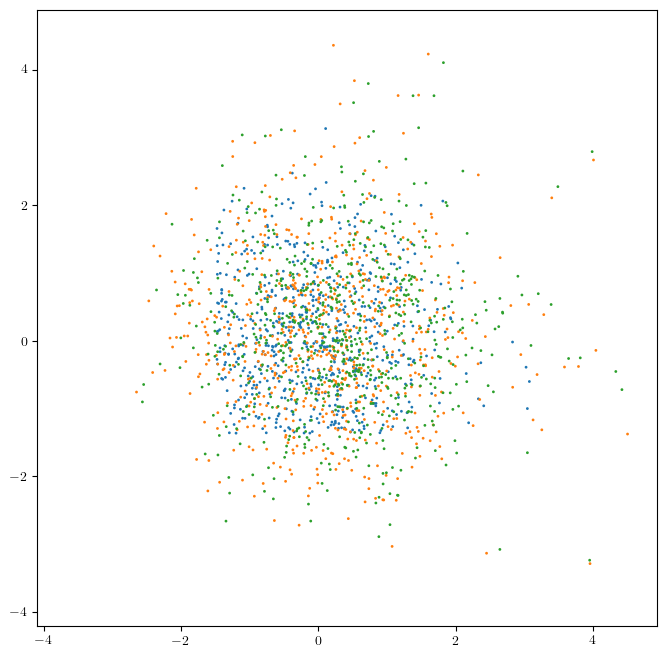

In [106]:
rng = np.random.default_rng(2)

n = 1024*64
n_classes = 3
n_dim = 2

# Determine transformations to apply to each class
a_transf = 0.2*rng.chisquare(2, size=n_classes) #* 0
b_transf = 0.5*rng.normal(size=n_classes) #* 0
c_transf = 0.1*rng.normal(size=(n_classes,2))
d_transf = 0.001*rng.chisquare(2, size=n_classes)

# Draw true coordinates
x_true = rng.normal(size=(n,n_dim))

# Choose two classes for each coordinate to belong to
c_obs = rng.integers(0, n_classes, size=(2,n))
for i in range(10):
    idx = np.where(c_obs[0] == c_obs[1])[0]
    c_obs[1,idx] = rng.integers(0, n_classes, size=len(idx))

# Generate observations of each coordinate
x_obs = np.empty((2,n,n_dim))
for i in range(2):
    for k,(a,b,c,d) in enumerate(zip(a_transf,b_transf,c_transf,d_transf)):
        idx = (c_obs[i] == k)
        x = x_true[idx]
        x_obs[i,idx] = x + a*np.exp(b*x) + c + d*rng.normal(size=x.shape)

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=100)
kw = dict(edgecolors='none', s=4)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
class_color = colors[:n_classes]

for k in range(n_classes):
    for i in range(2):
        idx = np.where(c_obs[i,:1024] == k)[0]
        x = x_obs[i][idx]
        ax.scatter(x[:,0], x[:,1], c=class_color[k], **kw)

xylim = np.percentile(x_obs[0], [1., 99.], axis=0)
w = xylim[1] - xylim[0]
xylim[0] -= 0.4*w
xylim[1] += 0.4*w
# xlim = (np.max(xylim[0]), np.min(xylim[1]))
# ylim = xlim
xlim,ylim = xylim.T
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [107]:
batch_size = 256
n_epochs = 4

x_obs = x_obs.astype('f4')
c_obs = c_obs.astype('f4')
x0,x1 = x_obs
c0,c1 = c_obs
c0.shape = c0.shape + (1,)
c1.shape = c1.shape + (1,)

data = tf.data.Dataset.from_tensor_slices((x0,x1,c0,c1))
data = data.shuffle(buffer_size=batch_size*64)
data = data.repeat(n_epochs)
data = data.batch(batch_size, drop_remainder=True)

data

<BatchDataset element_spec=(TensorSpec(shape=(256, 2), dtype=tf.float32, name=None), TensorSpec(shape=(256, 2), dtype=tf.float32, name=None), TensorSpec(shape=(256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 1), dtype=tf.float32, name=None))>

In [114]:
hidden_size = 32
n_hidden = 3
l1_factor = 1e-3
l2_factor = 1e-2
sigma_x = 0.1

# bij = ODEBijector(n_dim, 1, hidden_size, n_hidden)
opt = keras.optimizers.Adam(learning_rate=1e-4)

variables = bij.trainable_variables

@tf.function
def grad_step(x0, x1, c0, c1):
    x0 = x0 + sigma_x * tf.random.normal(x0.shape)
    with tf.GradientTape() as g:
        x0_pred,s0 = bij.forward_with_s(x0, c=c0)
        x1_pred,s1 = bij.inverse_with_s(x0_pred, c=c1)
        chi2 = tf.reduce_sum((x1_pred-x1)**2, axis=1) / sigma_x**2
        chi2 = 5 * tf.math.asinh(chi2/5)
        chi2 = tf.reduce_mean(chi2)
#         s0 = tf.reduce_sum((x0_pred - x0)**2, axis=1)
#         s1 = tf.reduce_sum((x1_pred - x0_pred)**2, axis=1)
        length2 = s0**2 + s1**2
        penalty = (
            l1_factor * tf.reduce_mean(tf.math.sqrt(length2))
          + l2_factor * tf.reduce_mean(length2)
        )
        loss = chi2 + penalty
    grads = g.gradient(loss, variables)
    grads,norm = tf.clip_by_global_norm(grads, 100.)
    opt.apply_gradients(zip(grads, variables))
    return loss, penalty, norm

iter = tqdm(data)
loss_hist = []
penalty_hist = []
for x0,x1,c0,c1 in iter:
    loss, penalty, norm = grad_step(x0, x1, c0, c1)

    loss_hist.append(float(loss.numpy()))
    penalty_hist.append(float(penalty.numpy()))

    loss_avg = np.mean(loss_hist[-16:])
    penalty_avg = np.mean(penalty_hist[-16:])

    iter.set_postfix({
        'loss': loss_avg,
        'chi2': loss_avg - penalty_avg,
        'penalty': penalty_avg,
        'norm': float(norm.numpy())
    })

  0%|          | 0/1024 [00:00<?, ?it/s]

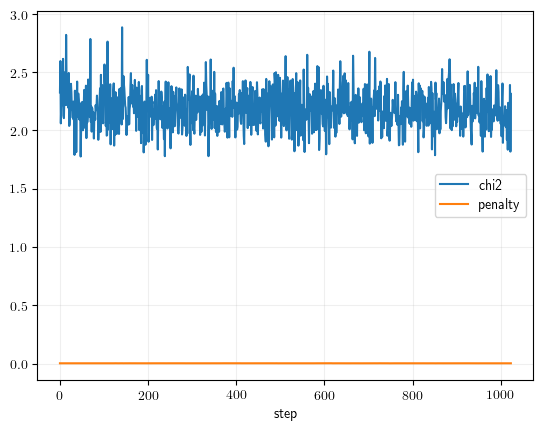

In [118]:
plt.plot(loss_hist, label='chi2')
plt.plot(penalty_hist, label='penalty')
plt.legend()
plt.xlabel('step')
plt.grid(True, alpha=0.2)

In [119]:
xt_pred = []

for x,c in zip(x_obs, c_obs):
    x0 = tf.constant(x[:1024].astype('f4'))
    c0 = tf.expand_dims(tf.constant(c[:1024].astype('f4')), 1)
    xt_pred.append(bij.return_path(x0, c0, 90).numpy())

xt_pred[0].shape

(90, 1024, 2)

In [120]:
! mkdir frames

mkdir: cannot create directory ‘frames’: File exists


  0%|          | 0/90 [00:00<?, ?it/s]

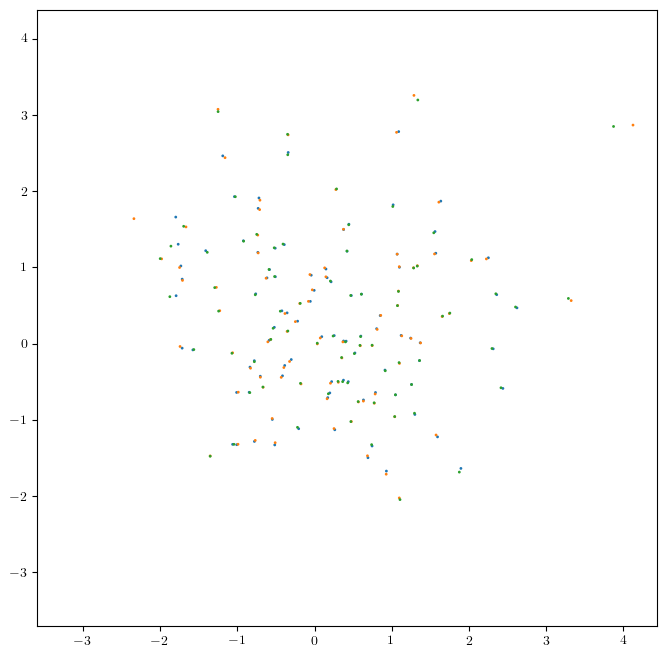

In [121]:
n_plot = 128
fname = 'frames/paths_{:03d}.png'

fig,ax = plt.subplots(figsize=(8,8), dpi=100)

kw = dict(edgecolors='none', s=4)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
class_color = colors[:n_classes]

xylim = np.percentile(x_obs[0], [1., 99.], axis=0)
w = xylim[1] - xylim[0]
xylim[0] -= 0.3*w
xylim[1] += 0.3*w
xlim,ylim = xylim.T

scatterplots = []

for k in range(n_classes):
    scatterplots.append([])
    for i in range(2):
        idx = np.where(c_obs[i,:n_plot] == k)[0]
        x = xt_pred[i][0][idx]
        sc = ax.scatter(x[:,0], x[:,1], c=class_color[k], **kw)
        scatterplots[-1].append(sc)

n_frames = xt_pred[0].shape[0]

for j in tqdm(range(n_frames)):
    for k in range(n_classes):
        for i in range(2):
            idx = np.where(c_obs[i,:n_plot] == k)[0]
            x = xt_pred[i][j][idx]
            sc = scatterplots[k][i]
            sc.set_offsets(np.c_[x[:,0], x[:,1]])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    fig.savefig(fname.format(j))

plt.show()

In [122]:
! ffmpeg -y -f image2 -framerate 30 -i "frames/paths_%03d.png" -pix_fmt yuv420p -c:v libx264 -crf 20 paths.mp4

ffmpeg version 2.8.15 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.5 (GCC) 20150623 (Red Hat 4.8.5-36)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -g -pipe -Wall -Wp,-D_FORTIFY_SOURCE=2 -fexceptions -fstack-protector-strong --param=ssp-buffer-size=4 -grecord-gcc-switches -m64 -mtune=generic' --extra-ldflags='-Wl,-z,relro ' --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libvo-amrwbenc --enable-version3 --enable-bzlib --disable-crystalhd --enable-gnutls --enable-ladspa --enable-libass --enable-libcdio --enable-libdc1394 --enable-libfdk-aac --enable-nonfree --disable-indev=jack --enable-libfreetype --enable-libgsm --enable-libmp3lame --enable-openal --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-libschroedinger --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libvorbis --enable-libv4l2 

# Merge real stellar catalogs

## Load stellar catalogs

In [9]:
import astropy
from astropy.table import Table
import os

In [10]:
data_dir = '/data/beegfs/astro-storage/groups/green/green/projects/gaia_Bp_Rp_reddening_variation/data/'

In [125]:
def extract_table(t, id_key, param_keys, extra_keys,
                  param_transf=None, param_errs=None):
    # Transformation to apply to each parameter
    if param_transf is None:
        param_transf = [lambda x:x for k in param_keys]
    
    # Remove rows with invalid IDs
    idx = (t[id_key] > 0) # Assume that id<=0 is invalid
    
    # Use default parameter errors, if none given
    n = np.count_nonzero(idx)
    d = len(param_keys)
    if param_errs is None:
        param_errs = 0.1*np.ones((n,d), dtype='f4')
    elif isinstance(param_errs, tuple) or isinstance(param_errs, list):
        errs = np.empty((n,d), dtype='f4')
        for i,e in enumerate(param_errs):
            errs[:,i] = e
        param_errs = errs

    def remove_masking(xx):
        if isinstance(xx, astropy.table.MaskedColumn):
            return xx.filled(np.nan).data
        else:
            return xx.data
    
    t_out = Table(
        dict(
            id=t[id_key][idx],
            x=np.stack([
                f(remove_masking(t[k][idx]))
                for f,k in zip(param_transf,param_keys)
            ], axis=1),
            x_err=param_errs,
            **{k:t[k][idx] for k in extra_keys}
        )
    )
    return t_out

### LAMOST Medium Resolution Survey (MRS)

In [329]:
fn = os.path.join(data_dir, 'lamost_mrs_cyclestarnet.h5')
t_lamost_mrs = Table.read(fn)
print(t_lamost_mrs.colnames)

['StarID', 'medID', 'Gaia_source_id', 'RA', 'Dec', 'SN_blue', 'SN_red', 'Teff', 'logg', 'FeH', 'vmic', 'vmac', 'CFe', 'NaFe', 'MgFe', 'SiFe', 'CaFe', 'TiFe', 'CrFe', 'MnFe', 'CoFe', 'NiFe', 'CuFe', 'Err_Teff', 'Err_logg', 'Err_FeH', 'Err_vmic', 'Err_vmac', 'Err_CFe', 'Err_NaFe', 'Err_MgFe', 'Err_SiFe', 'Err_CaFe', 'Err_TiFe', 'Err_CrFe', 'Err_MnFe', 'Err_CoFe', 'Err_NiFe', 'Err_CuFe', 'Flag_Teff', 'Flag_logg', 'Flag_FeH', 'Flag_vmic', 'Flag_vmac', 'Flag_CFe', 'Flag_NaFe', 'Flag_MgFe', 'Flag_SiFe', 'Flag_CaFe', 'Flag_TiFe', 'Flag_CrFe', 'Flag_MnFe', 'Flag_CoFe', 'Flag_NiFe', 'Flag_CuFe', 'Flag_quality']


In [330]:
idx = (
    (t_lamost_mrs['Flag_Teff'] == 0)
  & (t_lamost_mrs['Flag_logg'] == 0)
  & (t_lamost_mrs['Flag_FeH'] == 0)
  & (t_lamost_mrs['Flag_quality'] == 0)
)
t_lamost_mrs = t_lamost_mrs[idx]
print(f'LAMOST MRS: {len(t_lamost_mrs)} good sources.')

LAMOST MRS: 857657 good sources.


In [331]:
# param_cols = [
#     'Teff', 'Err_Teff',
#     'logg', 'Err_logg',
#     'FeH', 'Err_FeH'
# ]
# t_lamost_mrs.keep_columns([
#     'Gaia_source_id',
#     'MgFe', 'Err_MgFe',
#     'SiFe', 'Err_SiFe',
#     'Flag_MgFe',
#     'Flag_SiFe'
# ] + param_cols)
# t_lamost_mrs.rename_columns(param_cols, [s.lower()+'_lmrs' for s in param_cols])

In [332]:
# print(t_lamost_mrs.colnames)

In [338]:
id_col = 'Gaia_source_id'
param_cols = ('Teff', 'logg', 'FeH')
param_transf = (lambda x: np.log(x/5000), lambda x:x, lambda x:x)
extra_cols = ('MgFe', 'SiFe', 'Flag_MgFe', 'Flag_SiFe', 'RA', 'Dec')

t_lmrs = extract_table(
    t_lamost_mrs,
    id_col, param_cols, extra_cols,
    param_transf=param_transf
)
t_lmrs

id,x,x_err,MgFe,SiFe,Flag_MgFe,Flag_SiFe,RA,Dec
int64,float64[3],float32[3],float64,float64,int64,int64,float64,float64
2007385426887291520,-0.12626187967752386 .. 0.01,0.1 .. 0.1,0.057,0.059,0,0,343.13247,58.13707
2007178031509195776,-0.23037715082610358 .. -0.484,0.1 .. 0.1,0.216,0.158,0,0,343.0824,57.829343
2007179710828415232,-0.010412017414008424 .. -0.378,0.1 .. 0.1,0.075,0.047,0,0,343.15237,57.874716
2007180367971768192,0.21559029717568617 .. -0.319,0.1 .. 0.1,0.054,0.066,0,0,343.34882,57.947485
2007438409604543104,0.05296050382122151 .. -0.013,0.1 .. 0.1,-0.146,0.036,0,0,342.03345,58.342943
2007452424071586560,0.020876560227641682 .. -0.49,0.1 .. 0.1,-0.059,0.08,0,0,342.36096,58.45949
2007426314976716160,-0.004291194017241403 .. 0.243,0.1 .. 0.1,-0.11,0.037,0,0,342.06166,58.288553
2007462461422035456,-0.015339043922757221 .. 0.055,0.1 .. 0.1,-0.09,0.002,0,0,342.17886,58.4395
2007441295822380544,0.21908733598427763 .. 0.177,0.1 .. 0.1,-0.066,0.014,0,0,341.68264,58.354774


### APOGEE DR17

In [339]:
fn = os.path.join(data_dir, 'allStarLite-dr17-synspec_rev1.fits')
t_apogee = Table.read(fn)
print(t_apogee.colnames)

['APOGEE_ID', 'TELESCOPE', 'FIELD', 'ALT_ID', 'RA', 'DEC', 'GLON', 'GLAT', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'AK_TARG', 'AK_TARG_METHOD', 'AK_WISE', 'SFD_EBV', 'APOGEE_TARGET1', 'APOGEE_TARGET2', 'APOGEE2_TARGET1', 'APOGEE2_TARGET2', 'APOGEE2_TARGET3', 'APOGEE2_TARGET4', 'TARGFLAGS', 'SURVEY', 'PROGRAMNAME', 'NVISITS', 'SNR', 'SNREV', 'STARFLAG', 'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER', 'VERR', 'RV_TEFF', 'RV_LOGG', 'RV_FEH', 'RV_ALPHA', 'RV_CARB', 'RV_CHI2', 'RV_CCFWHM', 'RV_AUTOFWHM', 'RV_FLAG', 'N_COMPONENTS', 'MEANFIB', 'SIGFIB', 'MIN_H', 'MAX_H', 'MIN_JK', 'MAX_JK', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG', 'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG', 'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR', 'GAIAEDR3_R_MED_GEO', 'GAIAEDR3_R_LO_GEO', 'GAIAEDR3_R_HI_GEO', 'GAIAEDR3_R_MED_PHOTO

In [340]:
idx = (
    (t_apogee['ASPCAPFLAG'] & 2**7 == 0) # STAR_WARN
  & np.isfinite(t_apogee['TEFF'])
  & np.isfinite(t_apogee['LOGG'])
  & np.isfinite(t_apogee['M_H'])
  & np.isfinite(t_apogee['TEFF_ERR'])
  & np.isfinite(t_apogee['LOGG_ERR'])
  & np.isfinite(t_apogee['M_H_ERR'])
)
t_apogee = t_apogee[idx]
print(fr'{100*np.mean(idx):.2f}% ({np.count_nonzero(idx)}) of APOGEE sources pass cuts.')

89.45% (578792) of APOGEE sources pass cuts.


In [341]:
# param_cols = [
#     'TEFF', 'TEFF_ERR',
#     'LOGG', 'LOGG_ERR',
#     'M_H', 'M_H_ERR',
#     'ALPHA_M', 'ALPHA_M_ERR'
# ]
# t_apogee.keep_columns([
#     'GAIAEDR3_SOURCE_ID',
#     'RA', 'DEC',
#     'GLON', 'GLAT'
# ] + param_cols)
# t_apogee.rename_columns(param_cols, [s.lower()+'_apogee' for s in param_cols])

In [342]:
# print(t_apogee.colnames)

In [343]:
id_col = 'GAIAEDR3_SOURCE_ID'
param_cols = ('TEFF', 'LOGG', 'M_H')
param_transf = (lambda x: np.log(x/5000), lambda x:x, lambda x:x)
extra_cols = ('ALPHA_M','RA','DEC')

t_apo = extract_table(
    t_apogee,
    id_col, param_cols, extra_cols,
    param_transf=param_transf
)
t_apo

id,x,x_err,ALPHA_M,RA,DEC
int64,float32[3],float32[3],float32,float64,float64
538028216707715712,-0.29466346 .. -0.14768,0.1 .. 0.1,0.036922,0.000103,74.285408
2413929812587459072,0.095632456 .. -0.26875,0.1 .. 0.1,0.0909783,0.000832,-19.413851
422596679964513792,0.19881491 .. -0.2451,0.1 .. 0.1,0.0291593,0.001335,57.61953
422596679964513792,0.20896837 .. -0.22151,0.1 .. 0.1,0.0480663,0.001335,57.61953
4689447878791422208,-0.09312365 .. -1.1832,0.1 .. 0.1,0.008442001,0.001467,-73.394287
421077597267551104,0.0062332978 .. -0.16008,0.1 .. 0.1,0.055704,0.00285,57.173164
2772097619417608704,0.17323895 .. -0.26704,0.1 .. 0.1,0.0124087995,0.004322,15.430942
421086363305436800,-0.005092752 .. -0.51314,0.1 .. 0.1,0.10715,0.005558,57.354549
431594980053422720,-0.06582719 .. -0.068767,0.1 .. 0.1,0.0076940004,0.008802,63.463078


### LAMOST HotPayne

In [344]:
fn = os.path.join(data_dir, 'lamost/hot_payne.fits.gz')
t_lamost_hotpayne = Table.read(fn)
print(t_lamost_hotpayne.colnames)

['SpecID', 'RAdeg', 'DEdeg', 'snrg', 'Teff', 'e_Teff', 'logg', 'e_logg', '[Fe/H]', 'e_[Fe/H]', 'vsini', 'e_vsini', '[Si/H]', 'e_[Si/H]', 'corTeff-logg', 'corTeff-[Fe/H]', 'corlogg-[Fe/H]', 'corTeff-vsini', 'corlogg-vsini', 'corvsini-[Fe/H]', 'corTeff-[Si/H]', 'corlogg-[Si/H]', 'cor[Si/H]-[Fe/H]', 'corvsini-[Si/H]', 'chisqred', 'RV', 'e_RV', 'chi2ratio', 'uniqflag', 'StarID', 'sourceDR6oba', 'sourceZari21', 'sourceLiu19', 'GaiaEDR3', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'RUWE', 'rgeo', 'e_rgeo', 'E_rgeo', 'Fidelity', 'E(B-V)bayes19', 'E(B-V)pair', 'e_E(B-V)pair', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag', 'Q-2MASS', 'W1mag', 'e_W1mag', 'W2mag', 'e_W2mag', 'W3mag', 'e_W3mag', 'W4mag', 'e_W4mag', 'Q-WISE', 'VAR-WISE']


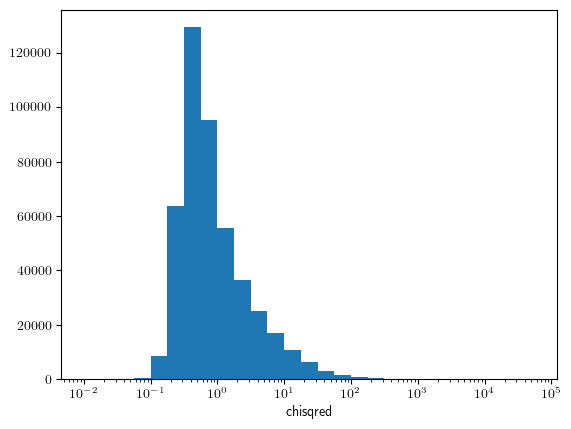

0.09853461566375554


In [345]:
plt.hist(t_lamost_hotpayne['chisqred'], bins=10**np.arange(-2.,5.,0.25))
plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')
plt.xlabel('chisqred')
plt.show()

print(np.mean(t_lamost_hotpayne['chisqred'] > 5.))

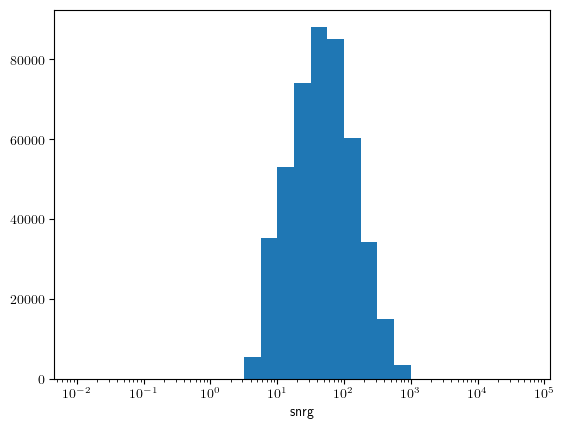

0.23631109341907616


In [346]:
plt.hist(t_lamost_hotpayne['snrg'], bins=10**np.arange(-2.,5.,0.25))
plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')
plt.xlabel('snrg')
plt.show()

print(np.mean(t_lamost_hotpayne['snrg'] < 20.))

0.7536051797586504


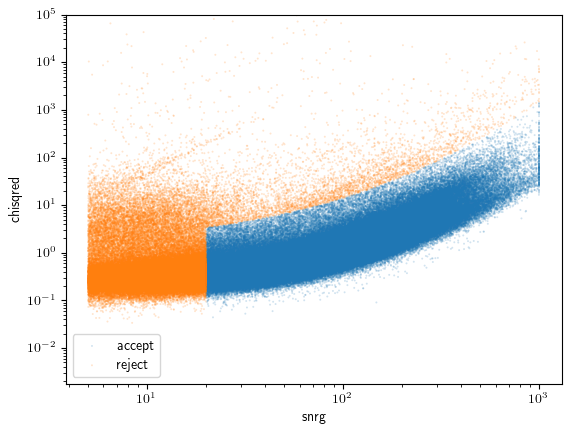

In [347]:
rchi2_max = lambda snr: np.exp(0.02*np.log(snr)**3 + np.log(2))
idx = (
    (t_lamost_hotpayne['chisqred'] < rchi2_max(t_lamost_hotpayne['snrg']))
#     (t_lamost_hotpayne['chisqred'] < 100.)
  & (t_lamost_hotpayne['snrg'] > 20.)
  & np.isfinite(t_lamost_hotpayne['e_Teff'])
  & np.isfinite(t_lamost_hotpayne['e_logg'])
  & np.isfinite(t_lamost_hotpayne['e_[Fe/H]'])
)
print(np.mean(idx))

kw = dict(edgecolors='none', alpha=0.2, s=2)

plt.scatter(
    t_lamost_hotpayne['snrg'][idx],
    t_lamost_hotpayne['chisqred'][idx],
    label='accept',
    **kw
)
plt.scatter(
    t_lamost_hotpayne['snrg'][~idx],
    t_lamost_hotpayne['chisqred'][~idx],
    label='reject',
    **kw
)

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.ylim(top=1e5)

# xlim = plt.gca().get_xlim()
# x_plot = np.exp(np.linspace(np.log(xlim[0]), np.log(xlim[1]), 100))
# plt.plot(x_plot, np.exp(0.02*np.log(x_plot)**3 + np.log(3)), alpha=0.7)

plt.xlabel('snrg')
plt.ylabel('chisqred')

plt.legend()
plt.show()

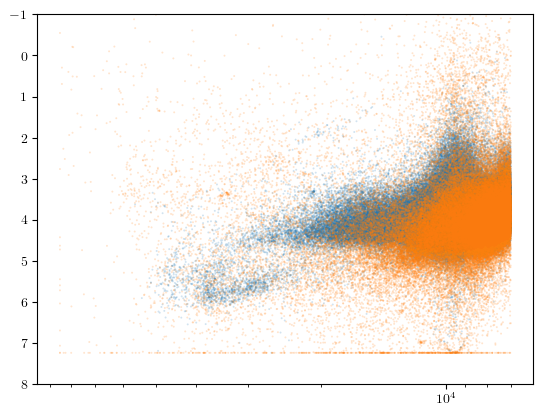

In [348]:
kw = dict(edgecolors='none', alpha=0.2, s=2)
plt.scatter(
    t_lamost_hotpayne['Teff'][idx],
    t_lamost_hotpayne['logg'][idx],
    label='accept',
    **kw
)
plt.scatter(
    t_lamost_hotpayne['Teff'][~idx],
    t_lamost_hotpayne['logg'][~idx],
    label='reject',
    **kw
)
# plt.xlim()
plt.ylim(8., -1.)
plt.gca().invert_xaxis()
plt.gca().set_xscale('log')
# plt.gca().invert_yaxis()

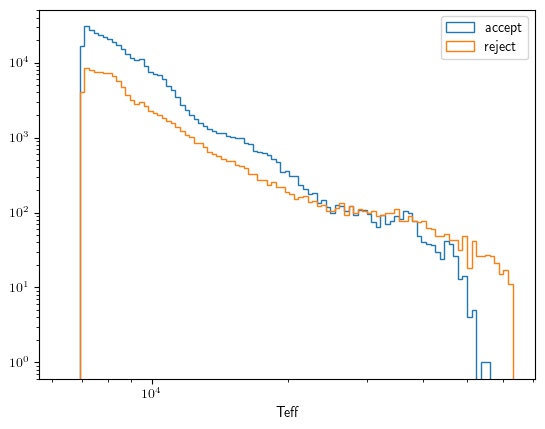

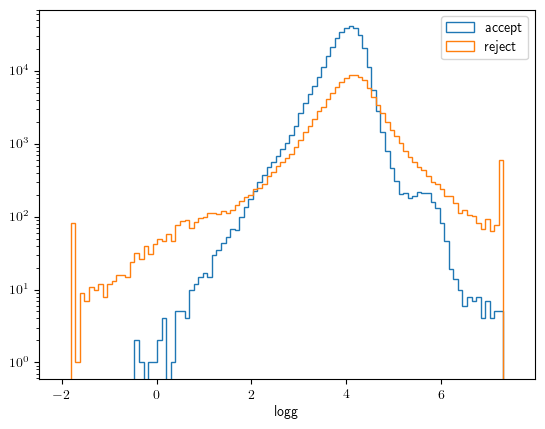

In [349]:
teff_bins = 10**np.linspace(3.8, 4.8, 100)
kw = dict(bins=teff_bins, histtype='step', log=True)
plt.hist(t_lamost_hotpayne['Teff'][idx], label='accept', **kw)
plt.hist(t_lamost_hotpayne['Teff'][~idx], label='reject', **kw)
plt.gca().set_xscale('log')
plt.legend()
plt.xlabel('Teff')
plt.show()

logg_bins = np.linspace(-2., 7.5, 100)
kw = dict(bins=logg_bins, histtype='step', log=True)
plt.hist(t_lamost_hotpayne['logg'][idx], label='accept', **kw)
plt.hist(t_lamost_hotpayne['logg'][~idx], label='reject', **kw)
plt.legend()
plt.xlabel('logg')
plt.show()

In [350]:
t_lamost_hotpayne = t_lamost_hotpayne[idx]

In [351]:
id_col = 'GaiaEDR3'
param_cols = ('Teff', 'logg', '[Fe/H]')
param_transf = (lambda x: np.log(x/5000), lambda x:x, lambda x:x)
extra_cols = ('[Si/H]','RAdeg','DEdeg')

t_lhp = extract_table(
    t_lamost_hotpayne,
    id_col, param_cols, extra_cols,
    param_transf=param_transf,
    param_errs=(0.02,0.1,0.1)
)
t_lhp

id,x,x_err,[Si/H],RAdeg,DEdeg
,,,[-],deg,deg
int64,float64[3],float32[3],float64,float64,float64
393923478296659200,0.33658651580538396 .. -0.780822,0.02 .. 0.1,-1.153285,0.008644,50.380315
420512590034739840,0.49420831794255293 .. -0.239353,0.02 .. 0.1,-0.354930,0.011984,55.573492
422632272352729984,0.3834784976560117 .. -0.020988,0.02 .. 0.1,-0.492370,0.012862,58.019821
387298370975979520,0.5663927722144464 .. -0.296435,0.02 .. 0.1,-0.458293,0.014918,47.794382
395601470479535616,0.3876269499782845 .. -0.387022,0.02 .. 0.1,-0.932749,0.018559,51.662715
420945793315071872,0.7570323633184699 .. -0.636348,0.02 .. 0.1,-0.614087,0.019518,56.620705
423186464874496128,0.5878422189145218 .. -0.970531,0.02 .. 0.1,-0.459372,0.022484,59.352074
422764248104464768,0.7747916816003244 .. -0.50138,0.02 .. 0.1,-0.662113,0.023678,58.594514


### GALAH

In [352]:
fn = os.path.join(data_dir, 'GALAH_DR3_main_allstar_v2.fits')
t_galah_dr3 = Table.read(fn)
t_galah_dr3

star_id,sobject_id,dr2_source_id,dr3_source_id,survey_name,field_id,flag_repeat,wg4_field,wg4_pipeline,flag_sp,teff,e_teff,irfm_teff,irfm_ebv,irfm_ebv_ref,logg,e_logg,fe_h,e_fe_h,flag_fe_h,fe_h_atmo,vmic,vbroad,e_vbroad,chi2_sp,alpha_fe,e_alpha_fe,nr_alpha_fe,flag_alpha_fe,flux_A_Fe,chi_A_Fe,Li_fe,e_Li_fe,nr_Li_fe,flag_Li_fe,C_fe,e_C_fe,nr_C_fe,flag_C_fe,O_fe,e_O_fe,nr_O_fe,flag_O_fe,Na_fe,e_Na_fe,nr_Na_fe,flag_Na_fe,Mg_fe,e_Mg_fe,nr_Mg_fe,flag_Mg_fe,Al_fe,e_Al_fe,nr_Al_fe,flag_Al_fe,Si_fe,e_Si_fe,nr_Si_fe,flag_Si_fe,K_fe,e_K_fe,nr_K_fe,flag_K_fe,Ca_fe,e_Ca_fe,nr_Ca_fe,flag_Ca_fe,Sc_fe,e_Sc_fe,nr_Sc_fe,flag_Sc_fe,Sc2_fe,e_Sc2_fe,nr_Sc2_fe,flag_Sc2_fe,Ti_fe,e_Ti_fe,nr_Ti_fe,flag_Ti_fe,Ti2_fe,e_Ti2_fe,nr_Ti2_fe,flag_Ti2_fe,V_fe,e_V_fe,nr_V_fe,flag_V_fe,Cr_fe,e_Cr_fe,nr_Cr_fe,flag_Cr_fe,Cr2_fe,e_Cr2_fe,nr_Cr2_fe,flag_Cr2_fe,Mn_fe,e_Mn_fe,nr_Mn_fe,flag_Mn_fe,Co_fe,e_Co_fe,nr_Co_fe,flag_Co_fe,Ni_fe,e_Ni_fe,nr_Ni_fe,flag_Ni_fe,Cu_fe,e_Cu_fe,nr_Cu_fe,flag_Cu_fe,Zn_fe,e_Zn_fe,nr_Zn_fe,flag_Zn_fe,Rb_fe,e_Rb_fe,nr_Rb_fe,flag_Rb_fe,Sr_fe,e_Sr_fe,nr_Sr_fe,flag_Sr_fe,Y_fe,e_Y_fe,nr_Y_fe,flag_Y_fe,Zr_fe,e_Zr_fe,nr_Zr_fe,flag_Zr_fe,Mo_fe,e_Mo_fe,nr_Mo_fe,flag_Mo_fe,Ru_fe,e_Ru_fe,nr_Ru_fe,flag_Ru_fe,Ba_fe,e_Ba_fe,nr_Ba_fe,flag_Ba_fe,La_fe,e_La_fe,nr_La_fe,flag_La_fe,Ce_fe,e_Ce_fe,nr_Ce_fe,flag_Ce_fe,Nd_fe,e_Nd_fe,nr_Nd_fe,flag_Nd_fe,Sm_fe,e_Sm_fe,nr_Sm_fe,flag_Sm_fe,Eu_fe,e_Eu_fe,nr_Eu_fe,flag_Eu_fe,ra_dr2,dec_dr2,parallax_dr2,parallax_error_dr2,r_est_dr2,r_lo_dr2,r_hi_dr2,r_len_dr2,rv_galah,e_rv_galah,rv_gaia_dr2,e_rv_gaia_dr2,red_flag,ebv,snr_c1_iraf,snr_c2_iraf,snr_c3_iraf,snr_c4_iraf,flag_guess,v_jk,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,ph_qual_tmass,w2mpro,w2mpro_error,ph_qual_wise,a_ks,e_a_ks,bc_ks,ruwe_dr2
,,,,,,,,,,K,K,K,mag,,log(cm.s**-2),log(cm.s**-2),,,,,km / s,km / s,km / s,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,mas,mas,pc,pc,pc,pc,,,km / s,km / s,,mag,,,,,,mag,mag,mag,mag,mag,mag,mag,,mag,mag,,mag,mag,mag,
bytes16,int64,int64,int64,bytes12,int64,int64,bytes6,bytes4,int64,float32,float64,float32,float32,bytes3,float32,float64,float32,float64,int64,float32,float32,float32,float64,float32,float64,float64,float64,int64,float32,float32,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int64,float64,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,bytes3,float64,float64,bytes4,float64,float64,float32,float64
03325271-6840304,131116000501002,4667368899326729856,4667368899326729856,galah_main,138,0,10k_2,lbol,0,4553.3545,137.06088556228917,4138.0,0.048,sfd,4.7149534,0.20121636742743593,-0.33501863,0.12021913955493135,0,-0.109347336,0.94853675,9.345594,2.5080910007092827,0.5873856,0.35136763119226394,0.07919326531297675,405.0,0,0.73446965,0.80794984,-0.18375580310821538,0.12854836388714738,1,1,--,--,--,32,1.2146472740173344,0.2138376266813869,1,1,0.14526838302612344,0.11489051187565578,1,0,-0.08849821090698207,0.19155067846881743,1

In [353]:
print(t_galah_dr3.colnames)

['star_id', 'sobject_id', 'dr2_source_id', 'dr3_source_id', 'survey_name', 'field_id', 'flag_repeat', 'wg4_field', 'wg4_pipeline', 'flag_sp', 'teff', 'e_teff', 'irfm_teff', 'irfm_ebv', 'irfm_ebv_ref', 'logg', 'e_logg', 'fe_h', 'e_fe_h', 'flag_fe_h', 'fe_h_atmo', 'vmic', 'vbroad', 'e_vbroad', 'chi2_sp', 'alpha_fe', 'e_alpha_fe', 'nr_alpha_fe', 'flag_alpha_fe', 'flux_A_Fe', 'chi_A_Fe', 'Li_fe', 'e_Li_fe', 'nr_Li_fe', 'flag_Li_fe', 'C_fe', 'e_C_fe', 'nr_C_fe', 'flag_C_fe', 'O_fe', 'e_O_fe', 'nr_O_fe', 'flag_O_fe', 'Na_fe', 'e_Na_fe', 'nr_Na_fe', 'flag_Na_fe', 'Mg_fe', 'e_Mg_fe', 'nr_Mg_fe', 'flag_Mg_fe', 'Al_fe', 'e_Al_fe', 'nr_Al_fe', 'flag_Al_fe', 'Si_fe', 'e_Si_fe', 'nr_Si_fe', 'flag_Si_fe', 'K_fe', 'e_K_fe', 'nr_K_fe', 'flag_K_fe', 'Ca_fe', 'e_Ca_fe', 'nr_Ca_fe', 'flag_Ca_fe', 'Sc_fe', 'e_Sc_fe', 'nr_Sc_fe', 'flag_Sc_fe', 'Sc2_fe', 'e_Sc2_fe', 'nr_Sc2_fe', 'flag_Sc2_fe', 'Ti_fe', 'e_Ti_fe', 'nr_Ti_fe', 'flag_Ti_fe', 'Ti2_fe', 'e_Ti2_fe', 'nr_Ti2_fe', 'flag_Ti2_fe', 'V_fe', 'e_V_fe', '

In [354]:
idx = (
    (t_galah_dr3['snr_c3_iraf'] > 30)
  & (t_galah_dr3['flag_sp'] == 0)
  & (t_galah_dr3['flag_fe_h'] == 0)
)
t_galah_dr3 = t_galah_dr3[idx]
print(np.mean(idx))

0.5530649658240042


In [355]:
id_col = 'dr3_source_id'
param_cols = ('teff', 'logg', 'fe_h')
param_transf = (lambda x: np.log(x/5000), lambda x:x, lambda x:x)
extra_cols = ('alpha_fe', 'flag_alpha_fe')

t_galah = extract_table(
    t_galah_dr3,
    id_col, param_cols, extra_cols,
    param_transf=param_transf
)
t_galah

id,x,x_err,alpha_fe,flag_alpha_fe
int64,float32[3],float32[3],float64,int64
4667368899326729856,-0.09357372 .. -0.33501863,0.1 .. 0.1,0.35136763119226394,0
4667320108498310656,0.1209323 .. 0.08286619,0.1 .. 0.1,-0.038428970792295826,0
4667320795693075584,-0.012071097 .. 0.1096735,0.1 .. 0.1,-0.08221199373250411,0
4667319455663284352,0.14664784 .. -0.42106676,0.1 .. 0.1,0.10966809570771893,0
4667319043346417792,-0.06618643 .. -1.203136,0.1 .. 0.1,0.17930676846144403,0
4667314370422016896,0.21036687 .. -0.3846922,0.1 .. 0.1,0.06803995892679174,0
4667307498474314624,0.06905414 .. -0.82132435,0.1 .. 0.1,0.29573042265322624,0
4667126968112646400,0.23672496 .. 0.04627657,0.1 .. 0.1,-0.028634879882749167,0
4667313167831183744,0.081404656 .. 0.0143790245,0.1 .. 0.1,0.05109579926286323,0


### DD-Payne (LAMOST LRS)

In [364]:
fn = os.path.join(data_dir, 'lamost/ddpayne_with_gaia.h5')
t_ddpayne = Table.read(fn)
t_ddpayne

SPECID,RA,DEC,SNR_U,SNR_G,SNR_R,SNR_I,SNR_Z,RV,RV_ERR,TEFF,TEFF_ERR,TEFF_FLAG,TEFF_GRADCORR,LOGG,LOGG_ERR,LOGG_FLAG,LOGG_GRADCORR,VMIC,VMIC_ERR,VMIC_FLAG,VMIC_GRADCORR,FEH,FEH_ERR,FEH_FLAG,FEH_GRADCORR,ALPHA_FE,ALPHA_FE_ERR,C_FE,C_FE_ERR,C_FE_FLAG,C_FE_GRADCORR,N_FE,N_FE_ERR,N_FE_FLAG,N_FE_GRADCORR,O_FE,O_FE_ERR,O_FE_FLAG,O_FE_GRADCORR,NA_FE,NA_FE_ERR,NA_FE_FLAG,NA_FE_GRADCORR,MG_FE,MG_FE_ERR,MG_FE_FLAG,MG_FE_GRADCORR,AL_FE,AL_FE_ERR,AL_FE_FLAG,AL_FE_GRADCORR,SI_FE,SI_FE_ERR,SI_FE_FLAG,SI_FE_GRADCORR,CA_FE,CA_FE_ERR,CA_FE_FLAG,CA_FE_GRADCORR,TI_FE,TI_FE_ERR,TI_FE_FLAG,TI_FE_GRADCORR,CR_FE,CR_FE_ERR,CR_FE_FLAG,CR_FE_GRADCORR,MN_FE,MN_FE_ERR,MN_FE_FLAG,MN_FE_GRADCORR,CO_FE,CO_FE_ERR,CO_FE_FLAG,CO_FE_GRADCORR,NI_FE,NI_FE_ERR,NI_FE_FLAG,NI_FE_GRADCORR,CU_FE,CU_FE_ERR,CU_FE_FLAG,CU_FE_GRADCORR,BA_FE,BA_FE_ERR,BA_FE_FLAG,BA_FE_GRADCORR,CHI2,CHI2RATIO,QFLAG_CHI2,CHI2_NA,CHI2RATIO_NA,QFLAG_CHI2NA,SNR_DPARALLAX,FLAG_SINGLESTAR,UQFLAG,STARID,SUBCLASS,FILENAME,index,source_id,ra_gaia,dec_gaia,separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,deg
bytes36,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,bytes4,float32,float32,bytes4,float32,bytes3,int16,bytes15,bytes10,bytes48,int64,int64,float64,float64,float64
20111024-F5902-01-001,332.202274,-2.056767,0.76,11.94,26.28,35.47,19.85,-38.940044,7.689677,4546.194,108.61385,1,0.7830999,3.4178967,0.25073984,1,0.755402,1.4803419,0.44890782,0,0.2439913,-1.4721066,0.17490259,1,0.8211115,0.30152404,0.06451062,0.121059954,0.0827225,1,0.7768615,-0.2687747,0.2192619,1,0.4954435,1.154818,0.2589388,1,0.6804764,-999.0,999.0,0,0.16305172,-999.0,999.0,0,0.6573531,-999.0,999.0,0,0.5746909,0.0472043,0.2084787,1,0.5879342,0.29398775,0.15651219,1,0.72058046,0.12961528,0.115971796,1,0.56485933,-999.0,999.0,0,0.5474243,-999.0,999.0,0,0.75086904,-0.5480199,0.19378707,1,0.416879,0.49461648,0.15446192,1,0.4731944,-999.0,999.0,0,0.15481378,-0.9690957,0.88108677,1,0.24501485,1.4244671,4.6220574,good,0.0,-1.0,bad,0.0,YES,1,S3321208-020324,G8,spec-55859-F5902_sp01-001.fits.gz,0,2676862492063809792,332.20225862477406,-2.056803662973053,6.92898142144228e-05
20111024-F5902-01-002,332.471576,-2.085015,0.11,3.69,20.06,33.83,22.44,35.22262,18.743025,4099.6357,116.68672,0,0.7144854,4.2065735,0.3755912,0,0.6968592,2.023125,0.33970135,0,0.11263688,-2.3911533,0.23108168,0,0.7281972,0.024181152,0.09537365,-999.0,999.0,0,0.5512851,-999.0,999.0,0,0.36306107,-999.0,999.0,0,0.42165866,-999.0,999.0,0,0.47037145,-999.0,999.0,0,0.63631,-999.0,999.0,0,0.7160149,-999.0,999.0,0,0.5712866,-999.0,999.0,0,0.62887514,-999.0,999.0,0,0.6117069,-999.0,999.0,0,0.7501514,-999.0,999.0,0,0.8570372,-999.0,999.0,0,0.39874685,-999.0,999.0,0,0.39454663,-999.0,999.0,0,0.13832052,-999.0,999.0,0,0.13923912,1.2527953,2.521022,good,0.0,-2.9602513,bad,-4.9224486,YES,1,S3322817-020506,K7,spec-55859-F5902_sp01-002.fits.gz,1,2676109292239283200,332.4715506360606,-2.085064930949917,3.7139823768405063e-05
20111024-F5902-01-004,332.431549,-2.062375,0.16,0.18,4.14,7.37,5.59,-1205.5225,50528.223,5325.3467,658.6197,1,0.60182565,0.105232686,1.1847372,1,0.1829677,2.7064576,2.693876,0,0.18568386,-2.6177557,1.2418091,1,0.5370105,-0.63306767,0.6940811,-0.19187333,0.4360624,1,0.14064318,-999.0,999.0,0,0.1689736,-999.0,999.0,0,0.063630156,-999.0,999.0,0,0.27498809,-999.0,999.0,0,0.04291493,-9

In [365]:
print(t_ddpayne.colnames)

['SPECID', 'RA', 'DEC', 'SNR_U', 'SNR_G', 'SNR_R', 'SNR_I', 'SNR_Z', 'RV', 'RV_ERR', 'TEFF', 'TEFF_ERR', 'TEFF_FLAG', 'TEFF_GRADCORR', 'LOGG', 'LOGG_ERR', 'LOGG_FLAG', 'LOGG_GRADCORR', 'VMIC', 'VMIC_ERR', 'VMIC_FLAG', 'VMIC_GRADCORR', 'FEH', 'FEH_ERR', 'FEH_FLAG', 'FEH_GRADCORR', 'ALPHA_FE', 'ALPHA_FE_ERR', 'C_FE', 'C_FE_ERR', 'C_FE_FLAG', 'C_FE_GRADCORR', 'N_FE', 'N_FE_ERR', 'N_FE_FLAG', 'N_FE_GRADCORR', 'O_FE', 'O_FE_ERR', 'O_FE_FLAG', 'O_FE_GRADCORR', 'NA_FE', 'NA_FE_ERR', 'NA_FE_FLAG', 'NA_FE_GRADCORR', 'MG_FE', 'MG_FE_ERR', 'MG_FE_FLAG', 'MG_FE_GRADCORR', 'AL_FE', 'AL_FE_ERR', 'AL_FE_FLAG', 'AL_FE_GRADCORR', 'SI_FE', 'SI_FE_ERR', 'SI_FE_FLAG', 'SI_FE_GRADCORR', 'CA_FE', 'CA_FE_ERR', 'CA_FE_FLAG', 'CA_FE_GRADCORR', 'TI_FE', 'TI_FE_ERR', 'TI_FE_FLAG', 'TI_FE_GRADCORR', 'CR_FE', 'CR_FE_ERR', 'CR_FE_FLAG', 'CR_FE_GRADCORR', 'MN_FE', 'MN_FE_ERR', 'MN_FE_FLAG', 'MN_FE_GRADCORR', 'CO_FE', 'CO_FE_ERR', 'CO_FE_FLAG', 'CO_FE_GRADCORR', 'NI_FE', 'NI_FE_ERR', 'NI_FE_FLAG', 'NI_FE_GRADCORR', '

/tmp/ipykernel_95833/1403631847.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(ddpayne_snr_tot), range=(0,4), bins=100)


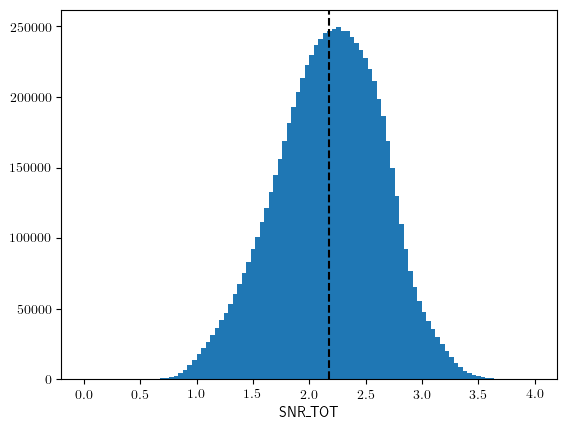

In [368]:
ddpayne_snr_tot = np.zeros(len(t_ddpayne))
for b in 'UGRIZ':
    ddpayne_snr_tot += t_ddpayne[f'SNR_{b}']
plt.hist(np.log10(ddpayne_snr_tot), range=(0,4), bins=100)
plt.xlabel('SNR_TOT')
plt.axvline(np.log10(150), c='k', ls='--')
plt.show()

In [369]:
idx = (
    (t_ddpayne['QFLAG_CHI2'] == b'good')
  & (t_ddpayne['QFLAG_CHI2NA'] == b'good')
  & (t_ddpayne['FLAG_SINGLESTAR'] == b'YES')
  & (t_ddpayne['UQFLAG'] == 1)
  & (ddpayne_snr_tot > 150)
  # & (
  #       (t_ddpayne['SNR_U'] > 20)
  #     | (t_ddpayne['SNR_G'] > 20)
  #     | (t_ddpayne['SNR_R'] > 20)
  #     | (t_ddpayne['SNR_I'] > 20)
  #     | (t_ddpayne['SNR_Z'] > 20)
  #   )
  & (t_ddpayne['TEFF'] > -9998)
  & (t_ddpayne['FEH'] > -998)
  & (t_ddpayne['LOGG'] > -998)
  & (t_ddpayne['TEFF_FLAG'] == 1)
  & (t_ddpayne['FEH_FLAG'] == 1)
  & (t_ddpayne['LOGG_FLAG'] == 1)
)
print(f'{np.mean(idx)*100:.2f}% of stars ({np.count_nonzero(idx)}) pass cuts')

28.95% of stars (2228330) pass cuts


In [372]:
t_ddpayne = t_ddpayne[idx]
ddpayne_snr_tot = ddpayne_snr_tot[idx]

/tmp/ipykernel_95833/3967165180.py:27: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


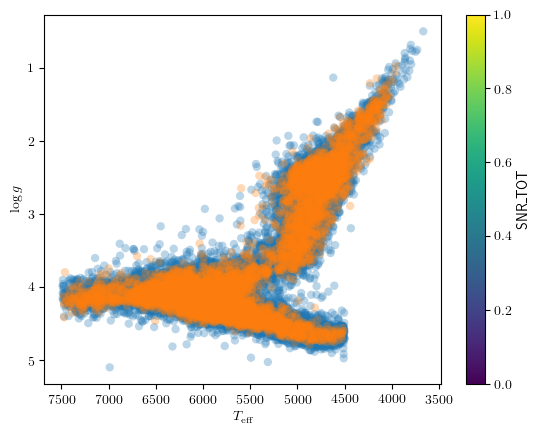

In [374]:
flag = 'SNR_TOT'
# plot_idx = slice(None,None,100)
# plot_idx = np.where(ddpayne_snr_tot > 10)[0][::100]
# plt.scatter(
#     t_ddpayne['TEFF'][plot_idx],
#     t_ddpayne['LOGG'][plot_idx],
#     c=ddpayne_snr_tot[plot_idx],
#     # c=t_ddpayne[flag][plot_idx],
#     edgecolors='none',
#     alpha=0.3,
#     norm=LogNorm(vmin=10)
# )
for snr_min in (150, 500):
    plot_idx = np.where(ddpayne_snr_tot > snr_min)[0][::100]
    plt.scatter(
        t_ddpayne['TEFF'][plot_idx],
        t_ddpayne['LOGG'][plot_idx],
        edgecolors='none',
        alpha=0.3
    )
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{\rm eff}$')
plt.ylabel(r'$\log g$')
cb = plt.colorbar(label=flag)
cb.set_alpha(1)
cb.draw_all()
plt.show()

In [375]:
id_col = 'source_id'
param_cols = ('TEFF', 'LOGG', 'FEH')
param_transf = (lambda x: np.log(x/5000), lambda x:x, lambda x:x)
extra_cols = ('ALPHA_FE', 'ALPHA_FE_ERR')

t_ddp = extract_table(
    t_ddpayne,
    id_col, param_cols, extra_cols,
    param_transf=param_transf
)
t_ddp

id,x,x_err,ALPHA_FE,ALPHA_FE_ERR
int64,float32[3],float32[3],float32,float32
2677134896069602688,-0.074954055 .. -0.02804696,0.1 .. 0.1,0.07655059,0.022982087
2677118884431510144,0.130897 .. -0.15511203,0.1 .. 0.1,0.13253073,0.020197783
2677121014735284352,-0.04981 .. -0.10096195,0.1 .. 0.1,0.14502165,0.019386442
2677119228028891008,0.1364395 .. -0.5271573,0.1 .. 0.1,0.17541155,0.023303514
2676818649037641344,0.12009757 .. 0.1259587,0.1 .. 0.1,0.036867946,0.01967124
2679829489831767552,0.05872119 .. -0.26088905,0.1 .. 0.1,0.097720034,0.024625592
2676819301872724992,-0.027944263 .. -0.35448334,0.1 .. 0.1,0.16883564,0.026499715
2676806829287694080,0.1094179 .. -0.6276328,0.1 .. 0.1,0.21201766,0.027782269
2676923446239782144,0.15215154 .. -0.7884946,0.1 .. 0.1,0.1813226,0.03016515


### Join catalogs

In [376]:
def extract_pairs(t0, t1, c=(0,1), rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    t_joined = astropy.table.join(
        t0, t1,
        keys='id',
        join_type='inner',
        table_names=('0','1')
    )
    print(f'{len(t_joined)} pairs.')
    n,d = t_joined['x_0'].shape
    
    k = rng.integers(0, 2, size=n)

    x0 = np.empty((n,3), dtype='f4')
    x1 = np.empty((n,3), dtype='f4')
    xe0 = np.empty((n,3), dtype='f4')
    xe1 = np.empty((n,3), dtype='f4')
    c0 = np.empty((n,), dtype='i4')
    c1 = np.empty((n,), dtype='i4')

    # Order: (x0,x1) = (t0,t1)
    idx = (k == 0)
    x0[idx] = t_joined['x_0'][idx]
    xe0[idx] = t_joined['x_err_0'][idx]
    c0[idx] = c[0]
    x1[idx] = t_joined['x_1'][idx]
    xe1[idx] = t_joined['x_err_1'][idx]
    c1[idx] = c[1]

    # Order: (x0,x1) = (t1,t0)
    idx = (k == 1)
    x0[idx] = t_joined['x_1'][idx]
    xe0[idx] = t_joined['x_err_1'][idx]
    c0[idx] = c[1]
    x1[idx] = t_joined['x_0'][idx]
    xe1[idx] = t_joined['x_err_0'][idx]
    c1[idx] = c[0]
    
    # c0.shape = (-1,1)
    # c1.shape = (-1,1)
    
    return {'x0':x0, 'x1':x1, 'xe0':xe0, 'xe1':xe1, 'c0':c0, 'c1':c1}

In [377]:
tables = [t_apo, t_lmrs, t_lhp, t_galah, t_ddp]
rng = np.random.default_rng(3)

pair_dict = {}

# Extract matches for each pair of tables
for j in range(len(tables)):
    for k in range(j+1,len(tables)):
        print(f'Extracting pairs for tables {j} & {k} ...')
        res = extract_pairs(tables[j], tables[k], c=(j,k), rng=rng)
        for key in res:
            if key not in pair_dict:
                pair_dict[key] = []
            pair_dict[key].append(res[key])

# Concatenate arrays and randomize their order
n = sum([len(x) for x in pair_dict['x0']])
idx = np.arange(n)
rng.shuffle(idx)
for key in pair_dict:
    pair_dict[key] = np.concatenate(pair_dict[key], axis=0)[idx]

Extracting pairs for tables 0 & 1 ...
94962 pairs.
Extracting pairs for tables 0 & 2 ...
982 pairs.
Extracting pairs for tables 0 & 3 ...
23878 pairs.
Extracting pairs for tables 0 & 4 ...
100555 pairs.
Extracting pairs for tables 1 & 2 ...
27528 pairs.
Extracting pairs for tables 1 & 3 ...
18585 pairs.
Extracting pairs for tables 1 & 4 ...
311206 pairs.
Extracting pairs for tables 2 & 3 ...
828 pairs.
Extracting pairs for tables 2 & 4 ...
59950 pairs.
Extracting pairs for tables 3 & 4 ...
16127 pairs.


In [378]:
# Extract control points from each table
ctrl_dict = {'x_control':[], 'xe_control':[], 'c_control':[]}

n_max = pair_dict['x0'].shape[0] // (len(tables)-1)

for i,t in enumerate(tables):
    print(f'Extracting control points from table {i} ...')
    idx = np.arange(len(t))
    rng.shuffle(idx)
    idx = idx[:n_max]
    print(f'  --> {len(idx)} control points.')
    ctrl_dict['x_control'].append(t['x'][idx].astype('f4'))
    ctrl_dict['xe_control'].append(t['x_err'][idx].astype('f4'))
    ctrl_dict['c_control'].append(np.full(len(idx), i, dtype='i4'))

# Concatenate arrays and randomize their order
n = sum([len(x) for x in ctrl_dict['x_control']])
idx = np.arange(n)
rng.shuffle(idx)
for key in ctrl_dict:
    ctrl_dict[key] = np.concatenate(ctrl_dict[key], axis=0)[idx]

Extracting control points from table 0 ...
  --> 163650 control points.
Extracting control points from table 1 ...
  --> 163650 control points.
Extracting control points from table 2 ...
  --> 163650 control points.
Extracting control points from table 3 ...
  --> 163650 control points.
Extracting control points from table 4 ...
  --> 163650 control points.


In [75]:
# t_apo_lmrs = astropy.table.join(
#     t_apogee, t_lamost_mrs,
#     keys_left='GAIAEDR3_SOURCE_ID',
#     keys_right='Gaia_source_id',
#     join_type='inner',
#     table_names=('apogee','lmrs')
# )

In [76]:
# plt.hist2d(
#     t_apo_lmrs['RA'], t_apo_lmrs['DEC'],
#     bins=50, range=[(0,360),(-20,80)],
#     norm=LogNorm()
# )
# plt.gca().invert_xaxis()
# plt.xlabel('RA')
# plt.ylabel('Dec')
# plt.show()

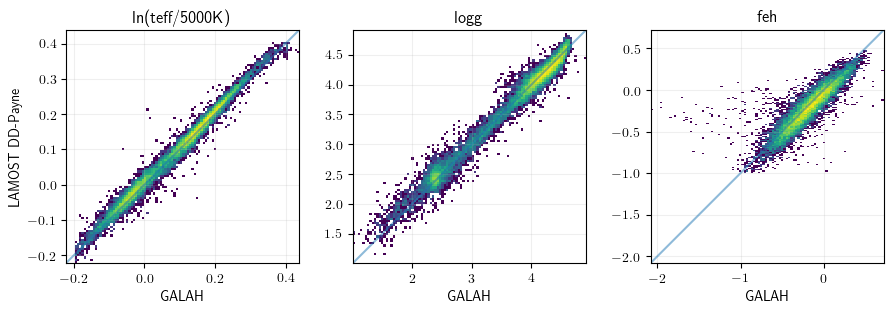

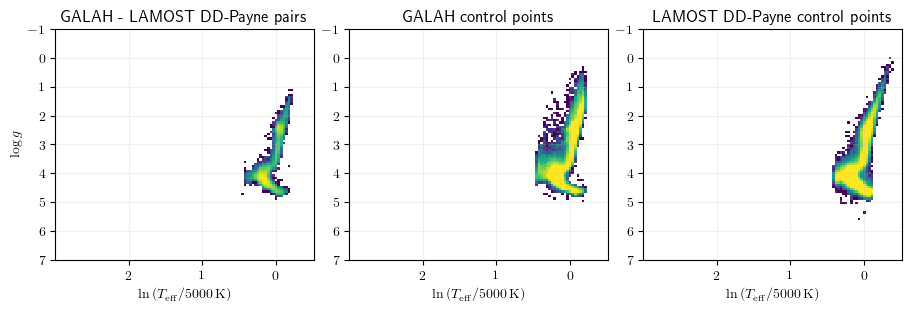

In [383]:
# Which catalogs to plot
c = (3,4)

cat_labels = ['APOGEE', 'LAMOST MRS', 'LAMOST HotPayne', 'GALAH', 'LAMOST DD-Payne']

# Comparison of 
fig,ax_arr = plt.subplots(
    1,3, figsize=(9,3),
    subplot_kw={'aspect':'equal'},
    layout='constrained'
)

idx0 = (
    (pair_dict['c0']==c[0])
  & (pair_dict['c1']==c[1])
)
idx1 = (
    (pair_dict['c1']==c[0])
  & (pair_dict['c0']==c[1])
)
x = np.concatenate([pair_dict['x0'][idx0], pair_dict['x1'][idx1]], axis=0)
y = np.concatenate([pair_dict['x1'][idx0], pair_dict['x0'][idx1]], axis=0)

param_labels = ['ln(teff/5000K)', 'logg', 'feh']

for i,(ax,p) in enumerate(zip(ax_arr.flat,param_labels)):
    ax.hist2d(
        x[:,i],
        y[:,i],
        bins=100,# range=[(0,360),(-20,80)],
        norm=LogNorm()
    )
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xlim = (min(xlim[0],ylim[0]), max(xlim[1],ylim[1]))
    ax.plot(xlim, xlim, alpha=0.5)
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)
    ax.set_title(p)
    
    ax.set_xlabel(cat_labels[c[0]])
    if i == 0:
        ax.set_ylabel(cat_labels[c[1]])
        
    ax.grid(True, alpha=0.2)

plt.show()

# Kiel diagrams of pairs and control points
fig,ax_arr = plt.subplots(1,3, figsize=(9,3), layout='constrained')
xlabel = r'$\ln \left( T_{\rm eff} / 5000\,\mathrm{K} \right)$'
xlim = list(np.log(np.array([3., 100.])/5))
ylim = [-1., 7.]
kw = dict(range=[xlim,ylim], bins=100, norm=LogNorm())

ax = ax_arr[0]
ax.hist2d(x[:,0], y[:,1], **kw)
ax.set_xlim(xlim[::-1])
ax.set_ylim(ylim[::-1])
ax.set_xlabel(xlabel)
ax.set_ylabel(r'$\log g$')
ax.set_title(f'{cat_labels[c[0]]} - {cat_labels[c[1]]} pairs')
ax.grid(True, alpha=0.2)

for i in range(2):
    ax = ax_arr[i+1]
    idx = (ctrl_dict['c_control']==c[i])
    ax.hist2d(
        ctrl_dict['x_control'][idx,0],
        ctrl_dict['x_control'][idx,1],
        **kw
    )
    ax.set_xlim(xlim[::-1])
    ax.set_ylim(ylim[::-1])
    ax.set_xlabel(r'$\ln\left( T_{\rm eff}/5000\,\mathrm{K} \right)$')
    ax.set_title(f'{cat_labels[c[i]]} control points')
    ax.grid(True, alpha=0.2)

plt.show()

## Map stellar parameters onto common scale

In [499]:
batch_size = 2048
n_epochs = 32

data_pairs = tf.data.Dataset.from_tensor_slices(tuple([
    pair_dict[k] for k in ('x0','x1','xe0','xe1','c0','c1')
]))
data_pairs = data_pairs.shuffle(buffer_size=batch_size*64)
data_pairs = data_pairs.repeat(n_epochs)
data_pairs = data_pairs.batch(batch_size, drop_remainder=True)

data_pairs

<BatchDataset element_spec=(TensorSpec(shape=(2048, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2048, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2048, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2048, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2048,), dtype=tf.int32, name=None), TensorSpec(shape=(2048,), dtype=tf.int32, name=None))>

In [500]:
data_ctrl = tf.data.Dataset.from_tensor_slices(tuple([
    ctrl_dict[k] for k in ('x_control','xe_control','c_control')
]))
data_ctrl = data_ctrl.shuffle(buffer_size=batch_size*64)
data_ctrl = data_ctrl.repeat(n_epochs)
data_ctrl = data_ctrl.batch(batch_size, drop_remainder=True)

data_ctrl

<BatchDataset element_spec=(TensorSpec(shape=(2048, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2048, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2048,), dtype=tf.int32, name=None))>

In [501]:
print(f'{min([len(data_pairs),len(data_ctrl)])} steps expected.')

10228 steps expected.


In [502]:
def plot_loss_hist(loss_hist, penalty_pair_hist,
                   penalty_ctrl_hist, penalty_div_hist):
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(8,4), layout='constrained')
    
    ax0.semilogy(loss_hist, label='loss')
    ax0.semilogy(penalty_pair_hist, label='penalty (pairs)')
    ax0.semilogy(penalty_ctrl_hist, label='penalty (control)')
    ax0.semilogy(penalty_div_hist, label='penalty (div)')
    ax0.legend(loc='upper right')
    
    def smooth_time_series(x, n_smooth=None):
        if n_smooth is None:
            n_smooth = np.clip(len(x)//16, 4, 128)
        w = np.kaiser(2*n_smooth,5)
        w /= np.sum(w)
        x_conv = scipy.ndimage.convolve(x, w, mode='reflect')
        return x_conv
    
    loss_smooth = smooth_time_series(loss_hist)
    
    n = len(loss_hist)
    l, = ax1.plot(np.arange(n//2,n), loss_hist[n//2:], alpha=0.25)
    ax1.plot(
        np.arange(n//2,n),
        loss_smooth[n//2:],
        c=l.get_color()
    )
    
    for ax in (ax0,ax1):
        ax.set_xlabel('step')
        ax.grid(True, alpha=0.2)
    
    plt.show()

In [503]:
def plot_transformed_kiel(bij):
    n_plot = 1024*2
    xt_pred = []
    for k,t in enumerate(tables):
        x = tf.constant(t['x'][:n_plot].astype('f4'))
        c = k * tf.ones([n_plot], dtype=tf.int32)
        xt_pred.append(bij.return_path(x, c, 2).numpy())

    n_classes = len(xt_pred)
    
    fig,ax_arr = plt.subplots(1,2, figsize=(8,4), dpi=120)
    
    kw = dict(edgecolors='none', s=4, alpha=0.5)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    class_color = colors[:n_classes]
    
    x = np.concatenate([x[0] for x in xt_pred], axis=0)
    xylim = np.percentile(x[:,:2], [1., 99.], axis=0)
    w = xylim[1] - xylim[0]
    xylim[0] -= 0.3*w
    xylim[1] += 0.3*w
    xlim,ylim = xylim.T
    xlim = xlim[::-1]
    ylim = ylim[::-1]
    
    for j,ax in enumerate(ax_arr.flat):
        for k,label in enumerate(cat_labels):
            x = xt_pred[k][j,:n_plot,:]
            sc = ax.scatter(
                x[:,0], x[:,1],
                c=class_color[k],
                label=label,
                **kw
            )
        ax.set_xlabel(r'$\ln\left(T_{\rm eff}/5000\,\mathrm{K}\right)$')
        ax.grid(True, alpha=0.2)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    
    ax_arr[0].legend(loc='upper left')
    ax_arr[0].set_ylabel(r'$\log g$')
    ax_arr[0].set_title('Original')
    ax_arr[1].set_title('Transformed')
    
    plt.show()

In [ ]:
# Neural network structure
hidden_size = 256
n_hidden = 6

plot_every = 5*60.0 # seconds

# Regularization constants for path length
l1_path = 1e0
l2_path = 1e0
# sigma_x = 0.1

# Regularization constants for final distance of points
l1_total = 1e0
l2_total = 1e0
sigma_ctrl = 0.3

# Regularization constants for stretching/contraction of space
eps_div = 0.1
weight_div = 1e1

n_dim = pair_dict['x0'].shape[1]
n_cat = len(tables)

# Set up bijector model
bij = ODEBijector(n_dim, n_cat, hidden_size, n_hidden)
variables = bij.trainable_variables
n_variables = sum([np.prod(tf.shape(v)) for v in variables])
print(f'{n_variables} variables in model.')

# Set up optimizer
n_steps = min([len(data_pairs), len(data_ctrl)])
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    [n_steps//3, 2*n_steps//3], [1e-3, 1e-4, 1e-5]
)
opt = keras.optimizers.Adam(learning_rate=learning_rate)

# Function to take one training step
@tf.function
def grad_step(x0, x1, xe0, xe1, c0, c1, x_ctrl, xe_ctrl, c_ctrl):
    # Add in Gaussian uncertainties to x0
    x0 = x0 + xe0 * tf.random.normal(x0.shape)
    
    # Add in arbitrary scatter to control points
    x_ctrl = x_ctrl + sigma_ctrl * tf.random.normal(x_ctrl.shape)

    # Create a paired control point, to measure stretching/contraction
    x1_ctrl = x_ctrl + eps_div * tf.random.normal(x_ctrl.shape)
    
    with tf.GradientTape() as g:
        # Transform x0 to coordinate system of x1
        x0_pred,s0 = bij.forward_with_s(x0, c=c0)
        x1_pred,s1 = bij.inverse_with_s(x0_pred, c=c1)
        
        # Transform control points to common coordinate system
        x_ctrl_pred,s_ctrl = bij.forward_with_s(x_ctrl, c=c_ctrl)

        # Transform offset control points to common coordinate system
        x1_ctrl_pred,s_ctrl1 = bij.forward_with_s(x1_ctrl, c=c_ctrl)
        
        # Compare transformed x0 to x1
        chi2 = tf.reduce_sum(((x1_pred-x1)/xe1)**2, axis=1)
        chi2 = 5 * tf.math.asinh(chi2/5)
        chi2 = tf.reduce_mean(chi2)
#         s0 = tf.reduce_sum((x0_pred - x0)**2, axis=1)
#         s1 = tf.reduce_sum((x1_pred - x0_pred)**2, axis=1)
        
        # Penalties of pair transformations
        length2 = s0**2 + s1**2
        penalty = (
            l1_path * tf.reduce_mean(tf.math.sqrt(length2))
          + l2_path * tf.reduce_mean(length2)
        )
        
        # Penalties on control-point transformations
        length1_ctrl = tf.reduce_mean(tf.abs(x_ctrl_pred-x_ctrl)/xe_ctrl)
        length2_ctrl = tf.reduce_mean(((x_ctrl_pred-x_ctrl)/xe_ctrl)**2)
        penalty_ctrl = (
            l1_total * length1_ctrl
          + l2_total * length2_ctrl
          + l1_path * tf.reduce_mean(tf.math.abs(s_ctrl))
          + l2_path * tf.reduce_mean(s_ctrl**2)
        )

        # Penalties on stretching/contraction of space
        length_div = tf.reduce_sum((x1_ctrl-x_ctrl)**2, axis=1)
        length_div_p = tf.reduce_sum((x1_ctrl_pred-x_ctrl_pred)**2, axis=1)
        eps = 1e-2 * eps_div
        penalty_div = weight_div * tf.reduce_mean(
            tf.math.log((length_div+eps)/(length_div_p+eps))**2
        )
        
        loss = chi2 + penalty + penalty_ctrl + penalty_div
    
    # Calculate and apply gradients
    grads = g.gradient(loss, variables)
    grads,norm = tf.clip_by_global_norm(grads, 100.)
    opt.apply_gradients(zip(grads, variables))
    
    return loss, penalty, penalty_ctrl, penalty_div, norm

# Loop over batches of training data
loss_hist = []
penalty_pair_hist = []
penalty_ctrl_hist = []
penalty_div_hist = []

data_pairs_iter = tqdm(data_pairs)

t_last_plot = time.monotonic()

for i,(d_pair,d_ctrl) in enumerate(zip(data_pairs_iter, data_ctrl)):
    (x0,x1,xe0,xe1,c0,c1) = d_pair
    (x_ctrl,xe_ctrl,c_ctrl) = d_ctrl
    
    loss, penalty_pair, penalty_ctrl, penalty_div, norm = grad_step(
        x0, x1, xe0, xe1, c0, c1, # Pairs
        x_ctrl, xe_ctrl, c_ctrl  # Control points
    )

    loss_hist.append(float(loss.numpy()))
    penalty_pair_hist.append(float(penalty_pair.numpy()))
    penalty_ctrl_hist.append(float(penalty_ctrl.numpy()))
    penalty_div_hist.append(float(penalty_div.numpy()))

    loss_avg = np.mean(loss_hist[-16:])
    penalty_pair_avg = np.mean(penalty_pair_hist[-16:])
    penalty_ctrl_avg = np.mean(penalty_ctrl_hist[-16:])
    penalty_div_avg = np.mean(penalty_div_hist[-16:])

    # Update progress bar
    data_pairs_iter.set_postfix({
        'loss': loss_avg,
        'chi2': loss_avg-penalty_pair_avg-penalty_ctrl_avg,
        'penalty_p': penalty_pair_avg,
        'penalty_c': penalty_ctrl_avg,
        'penalty_d': penalty_div_avg,
        'norm': float(norm.numpy()),
        'lr': float(learning_rate(i).numpy())
    })

    # Make plots at regular intervals
    # if i % plot_every == plot_every-1:
    if time.monotonic() > t_last_plot+plot_every:
        t_last_plot = time.monotonic()
        plot_loss_hist(loss_hist, penalty_pair_hist,
                       penalty_ctrl_hist, penalty_div_hist)
        plot_transformed_kiel(bij)

343811 variables in model.


  0%|          | 0/10228 [00:00<?, ?it/s]

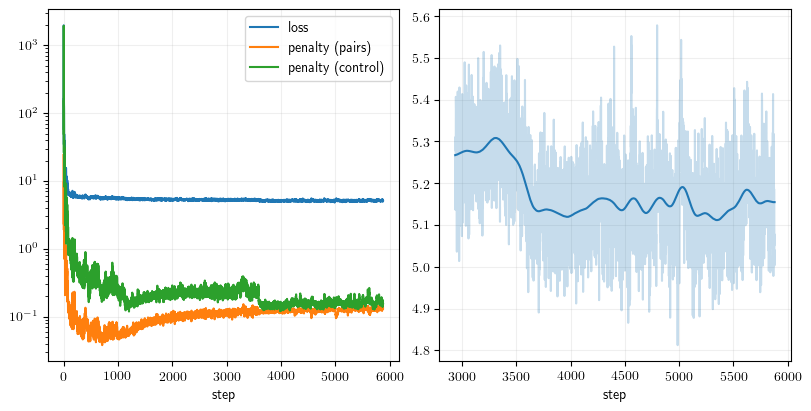

<function __main__.plot_loss_hist.<locals>.update_plot(loss_hist, penalty_pair_hist, penalty_ctrl_hist)>

In [295]:
plot_loss_hist(loss_hist, penalty_pair_hist, penalty_ctrl_hist)
plot_transformed_kiel(bij)

In [415]:
n_frames = 120
n_plot = 1024*2

# Control points
xt_pred = []

for k,t in enumerate(tables):
    x = tf.constant(t['x'][:n_plot].astype('f4'))
    c = k * tf.ones([n_plot], dtype=tf.int32)
    xt_pred.append(bij.return_path(x, c, n_frames).numpy())

xt_pred[0].shape

(120, 2048, 3)

In [482]:
# Pairs
xt_pair = {}

for j in range(len(tables)):
    for k in range(j+1,len(tables)):
        idx = np.where((pair_dict['c0']==j) & (pair_dict['c1']==k))[0][:n_plot]
        n = len(idx)
        print(f'({j},{k}) : {n} pairs')
        c = j * tf.ones([n], dtype=tf.int32)
        xt0 = bij.return_path(pair_dict['x0'][idx], c, n_frames).numpy()
        c = k * tf.ones([n], dtype=tf.int32)
        xt1 = bij.return_path(pair_dict['x1'][idx], c, n_frames).numpy()
        xt_pair[(j,k)] = (xt0,xt1)

(0,1) : 2048 pairs
(0,2) : 510 pairs
(0,3) : 2048 pairs
(0,4) : 2048 pairs
(1,2) : 2048 pairs
(1,3) : 2048 pairs
(1,4) : 2048 pairs
(2,3) : 407 pairs
(2,4) : 2048 pairs
(3,4) : 2048 pairs


In [471]:
xt_pair[(0,4)][0].shape

(120, 2048, 3)

frames/trajectories_pair12_{:03d}.png


  0%|          | 0/120 [00:00<?, ?it/s]

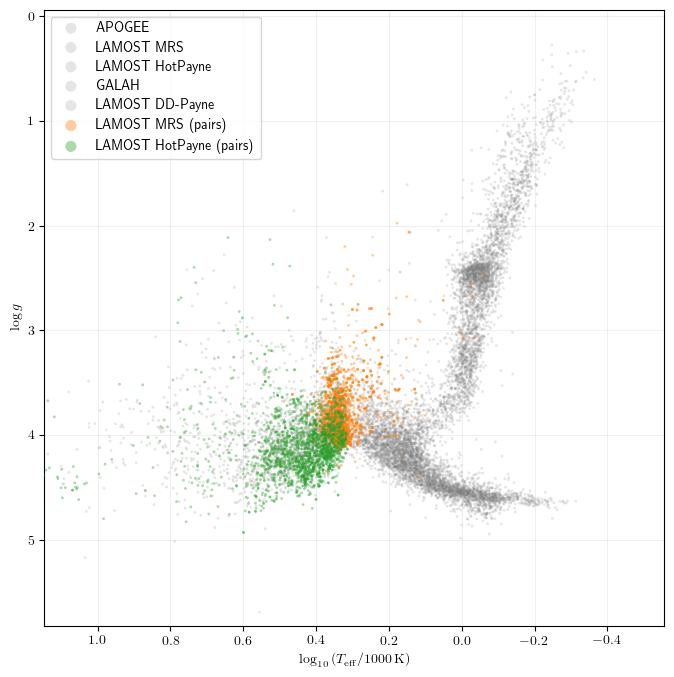

In [497]:
c_highlight = []
p_highlight = (1,2)

n_classes = len(xt_pred)

base_fname = 'trajectories'
if len(c_highlight):
    base_fname += '_control' + ''.join([str(s) for s in c_highlight])
if p_highlight is not None:
    base_fname += '_pair' + ''.join([str(s) for s in p_highlight])
fname = f'frames/{base_fname}_{{:03d}}.png'
print(fname)

fig,ax = plt.subplots(figsize=(8,8), dpi=100)

kw = dict(edgecolors='none', s=4)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
class_color = colors[:n_classes]

x = np.concatenate([x[0] for x in xt_pred], axis=0)
xylim = np.percentile(x[:,:2], [1., 99.], axis=0)
w = xylim[1] - xylim[0]
xylim[0] -= 0.3*w
xylim[1] += 0.3*w
xlim,ylim = xylim.T
xlim = xlim[::-1]
ylim = ylim[::-1]

scatterplots = []

for k,label in enumerate(cat_labels):
    highlight = (k in c_highlight)
    x = xt_pred[k][0,:n_plot,:]
    sc = ax.scatter(
        x[:,0], x[:,1],
        c=class_color[k] if highlight else 'gray',
        alpha=0.5 if highlight else 0.2,
        zorder=100 if highlight else 0,
        label=label,
        **kw
    )
    scatterplots.append(sc)

if p_highlight is not None:
    xtp = xt_pair[p_highlight]
    scatterplots_p = []
    for i,x in enumerate(xtp):
        sc = ax.scatter(
            x[0,:,0], x[0,:,1],
            c=class_color[p_highlight[i]],
            alpha=0.4,
            zorder=110,
            label=cat_labels[p_highlight[i]]+' (pairs)',
            **kw
        )
        scatterplots_p.append(sc)

ax.legend(loc='upper left', markerscale=4)
ax.set_xlabel(r'$\log_{10}\left(T_{\rm eff}/1000\,\mathrm{K}\right)$')
ax.set_ylabel(r'$\log g$')
ax.grid(True, alpha=0.2)

n_frames = xt_pred[0].shape[0]

for j in tqdm(range(n_frames)):
    for k in range(n_classes):
        x = xt_pred[k][j,:n_plot,:]
        sc = scatterplots[k]
        sc.set_offsets(np.c_[x[:,0], x[:,1]])
    if p_highlight is not None:
        xtp = xt_pair[p_highlight]
        for i,x in enumerate(xtp):
            sc = scatterplots_p[i]
            sc.set_offsets(np.c_[x[j,:,0], x[j,:,1]])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    fig.savefig(fname.format(j), dpi=200)

plt.show()

In [498]:
! ffmpeg -y -f image2 -framerate 30 -i "frames/{base_fname}_%03d.png" -pix_fmt yuv420p -c:v libx264 -crf 20 {base_fname}.mp4

ffmpeg version 2.8.15 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.5 (GCC) 20150623 (Red Hat 4.8.5-36)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -g -pipe -Wall -Wp,-D_FORTIFY_SOURCE=2 -fexceptions -fstack-protector-strong --param=ssp-buffer-size=4 -grecord-gcc-switches -m64 -mtune=generic' --extra-ldflags='-Wl,-z,relro ' --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libvo-amrwbenc --enable-version3 --enable-bzlib --disable-crystalhd --enable-gnutls --enable-ladspa --enable-libass --enable-libcdio --enable-libdc1394 --enable-libfdk-aac --enable-nonfree --disable-indev=jack --enable-libfreetype --enable-libgsm --enable-libmp3lame --enable-openal --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-libschroedinger --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libvorbis --enable-libv4l2 

  0%|          | 0/120 [00:00<?, ?it/s]

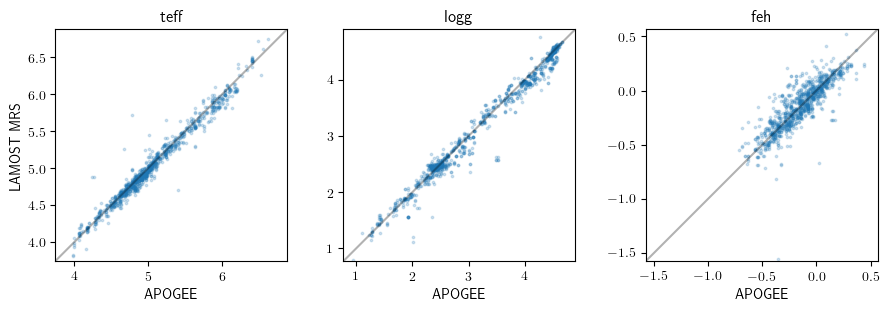

In [262]:
fname = 'frames/apogee_lamost_indivparams_{:03d}.png'

fig,ax_arr = plt.subplots(
    1,3,
    figsize=(9,3),
    subplot_kw={'aspect':'equal'},
    layout='constrained'
)

scatterplots = []

for i,(ax,p) in enumerate(zip(ax_arr.flat,['teff','logg','feh'])):
    sc = ax.scatter(
        xt_pred[0][0,:,i],
        xt_pred[1][0,:,i],
        s=3,
        alpha=0.2
    )
    scatterplots.append(sc)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xlim = (min(xlim[0],ylim[0]), max(xlim[1],ylim[1]))
    ax.plot(xlim, xlim, c='k', alpha=0.3)
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)
    ax.set_title(p)
    
    ax.set_xlabel('APOGEE')
    if i == 0:
        ax.set_ylabel('LAMOST MRS')

        
n_frames = xt_pred[0].shape[0]

for j in tqdm(range(n_frames)):
    for i,ax in enumerate(ax_arr):
        x = xt_pred[0][j,:,i]
        y = xt_pred[1][j,:,i]
        sc = scatterplots[i]
        xlim = ax.get_xlim()
        sc.set_offsets(np.c_[x, y])
        ax.set_xlim(xlim)
        ax.set_ylim(xlim)
    fig.savefig(fname.format(j), dpi=200)

plt.show()

In [263]:
! ffmpeg -y -f image2 -framerate 30 -i "frames/apogee_lamost_indivparams_%03d.png" -pix_fmt yuv420p -c:v libx264 -crf 20 apogee_lamost_indivparams.mp4

ffmpeg version 2.8.15 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.5 (GCC) 20150623 (Red Hat 4.8.5-36)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -g -pipe -Wall -Wp,-D_FORTIFY_SOURCE=2 -fexceptions -fstack-protector-strong --param=ssp-buffer-size=4 -grecord-gcc-switches -m64 -mtune=generic' --extra-ldflags='-Wl,-z,relro ' --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libvo-amrwbenc --enable-version3 --enable-bzlib --disable-crystalhd --enable-gnutls --enable-ladspa --enable-libass --enable-libcdio --enable-libdc1394 --enable-libfdk-aac --enable-nonfree --disable-indev=jack --enable-libfreetype --enable-libgsm --enable-libmp3lame --enable-openal --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-libschroedinger --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libvorbis --enable-libv4l2 